# Secure Key Distribution

In the digital age, secure communication is essential. To ensure that messages between two parties (let's call them Alice and Bob) remain private, they use encryption. Encryption relies on a **key**, a secret string of numbers that is used to encode and decode messages. However, sharing this key securely is a challenge. This process is called **key distribution**.

For example, imagine Alice wants to send a confidential message to Bob. If Eve (an eavesdropper) intercepts the key during transmission, she could decrypt Alice's messages without detection. Traditional methods of distributing keys often assume that Eve cannot access the key, but if she does, Alice and Bob might never know their communication has been compromised.

![bb84_1](assets/images/bb84_1.png)

The question is: **How can Alice and Bob share a key in a way that guarantees its secrecy and detects any eavesdropping?**

## Table of Contents
1. [Quantum Key Distribution Intro](#quantum-key-distribution)
2. [The BB84 Protocol](#the-bb84-protocol)
3. [The E91 Protocol](#the-e91-protocol)
4. [Sources & Literature](#sources--literature)
#
---

## Quantum Key Distribution

**Quantum Key Distribution (QKD)** uses the principles of quantum mechanics to address the challenges of secure key distribution. Unlike classical methods, QKD ensures that if an eavesdropper (Eve) tries to intercept the key, her presence will be detected.

The key insight comes from quantum mechanics: observing a quantum system disturbs it. In other words, Eve cannot intercept the quantum states used to transmit the key without introducing detectable anomalies. This fundamental property enables Alice and Bob to:

1. Share a key securely.
2. Detect any attempt by Eve to eavesdrop on their communication.

While our main topic is the E91 Protocol it is crucial to understand the BB84 Protocol on which it is based. So we will explain the BB84 Protocol in a short manner and highlight it's differnces to the E91 Protocol later on.


## The BB84 Protocol

Since Qubits are able to assume more positions than just 1 and 0 it is possible for Alice to send Bob information that is received by chance different on his end. In the BB84 Key Distribution Protocol Alice and Bob each measure in two different bases (green on Alice's side and blue/red on Bob's side). The bases are chosen at random so there is about a 1/3 chance both parties measure in the same basis.

In the illustration below you can see how Bob recevies a secret key from alice via Quantum Key Distribution without interception.

In real use-cases you will have to imagine that keys are normally much longer than 9 bits, for obvious security reasons.

![bb84_2](assets/images/bb84_2.png)

After transfering the information Alice and Bob will exchange their basis layout and compare. Bits measured in bases on Bob's side that are different from Alice's bases (the red marked bases) are discarded. Then from the remaining bits Alice and Bob pick a partial set and compare them. If there is an **eavesdropper** there is a high chance (growing the more bits you have to compare) that Bob will receive a bit, Alice sent, wrong.

Below you can view a code example for a **successfull** key exchange **without** an **eavesdropper**.


In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit_aer import AerSimulator
import numpy as np
from rich.table import Table
from rich.console import Console

n = 20
seed = 42

computational_basis = 'Z'
hadamard_basis = 'X'

alice_bases = np.random.choice([hadamard_basis, computational_basis], size=n) 
bob_bases = np.random.choice([hadamard_basis, computational_basis], size=n)
alice_bits = np.random.randint(2, size=n)

aer_simulator = AerSimulator()

alice_results = []
bob_results = []

for i in range(n):
    qreg = QuantumRegister(2, f'q{i}')
    creg = ClassicalRegister(2, f'c{i}')
    circuit = QuantumCircuit(qreg, creg)
    
    circuit.h(qreg[0])
    circuit.cx(qreg[0], qreg[1])

    if alice_bases[i] == hadamard_basis:
        circuit.h(qreg[0])
    circuit.measure(qreg[0], creg[0])

    if bob_bases[i] == hadamard_basis:
        circuit.h(qreg[1])
    circuit.measure(qreg[1], creg[1])

    result = aer_simulator.run(circuit, shots=1).result()
    counts = result.get_counts()

    for outcome in counts:
        alice_results.append(int(outcome[-1]))
        bob_results.append(int(outcome[-2]))

matching_bases = [alice_bases[i] == bob_bases[i] for i in range(n)]
key = [alice_results[i] for i in range(n) if matching_bases[i]]

table = Table(title="BB84 without Eavesdropper", show_header=True, header_style="bold white")

table.add_column("Bits from Alice", justify="center")
table.add_column("Bases from Alice", justify="center")
table.add_column(" ", justify="center")
table.add_column("Bits from Bob", justify="center")
table.add_column("Bases from Bob", justify="center")
table.add_column("Matching Bits", justify="center")

for i in range(n):
    table.add_row(
        str(alice_results[i]),
        alice_bases[i],
        f"[green]----->[/green]" if matching_bases[i] else "[red]----->[/red]",
        str(bob_results[i]),
        bob_bases[i],
        f"[green]{alice_results[i]}[/green]" if matching_bases[i] else f"[red]{bob_results[i]}[/red]"
    )

console = Console()
console.print(table)

                                   BB84 without Eavesdropper                                    
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Bits from Alice ┃ Bases from Alice ┃        ┃ Bits from Bob ┃ Bases from Bob ┃ Matching Bits ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│        0        │        X         │ -----> │       1       │       Z        │       1       │
│        1        │        X         │ -----> │       0       │       Z        │       0       │
│        1        │        X         │ -----> │       1       │       X        │       1       │
│        0        │        X         │ -----> │       0       │       Z        │       0       │
│        1        │        Z         │ -----> │       0       │       X        │       0       │
│        1        │        X         │ -----> │       0       │       Z        │       0       │
│        1        │        X         │ -----> │       1       │       X        │       1       │
│        0        │        Z         │ -----> │       0       │       Z        │       0       │
│        1        │        Z         │ -----> │       1       │       X        │       1       │
│        1        │        X         │ -----> │       1       │       X        │       1       │
│        1        │        X         │ -----> │       1       │       Z        │       1       │
│        0        │        X         │ -----> │       1       │       Z        │       1       │
│        0        │        X         │ -----> │       0       │       Z        │       0       │
│        0        │        Z         │ -----> │       0       │       Z        │       0       │
│        0        │        Z         │ -----> │       1       │       X        │       1       │
│        0        │        Z         │ -----> │       0       │       Z        │       0       │
│        0        │        X         │ -----> │       0       │       X        │       0       │
│        0        │        Z         │ -----> │       0       │       Z        │       0       │
│        0        │        Z         │ -----> │       0       │       X        │       0       │
│        0        │        X         │ -----> │       0       │       Z        │       0       │
└─────────────────┴──────────────────┴────────┴───────────────┴────────────────┴───────────────┘

In the table you generate above you can view how bits are transfered from Alice to Bob. You can change **n** at the start to repeat this code block with more or less bits. This will get especially interesting later on when adding Eve as an eavesdropper and comparing the BB84 Protocol to the E91 Protocol.

_As most security related matters, the more bits you add, the more sense this protocol makes._

---

### Detecting an Interception with the BB84 Protocol

There is a 25% chance per bit, that Alice and Bob use to check for an eavesdropper, that Eve can be detected. Below you can see how _(assuming you can not clone qubits or measure them in any other way without collapsing them from their superposition)_.

![e91_1](assets/images/e91_1.png)

In this case Eve was lucky and measured with same basis as Bob (the Z-Basis). This is a **50%** chance that she is right.

![e91_2](assets/images/e91_2.png)

This case, where Eve measures the qubit sent by Alice with the **wrong basis** sets her up for failure. Since it arrives in a Superposition at Bob, he could with a **50%** chance _(again)_ measure the wrong bit. So if this bit is then used by Alice and Bob to check if they have been intercepted, Eve will be detected.

0.5 * 0.5 = 0.25, a **25%** chance on every bit _(that is used for checking)_ that Eve is detected.

Now we will modify the code shown earlier to show how this protocol plays out **with** an **eavesdropper**.

_Make sure to test changing the number of bits **'n'** and the number of repeats **repeats**._

In [2]:
def bb84_with_eavesdropper(n):
    # Alice, Bob und Eve
    alice_bases = np.random.choice([hadamard_basis, computational_basis], size=n)
    bob_bases = np.random.choice([hadamard_basis, computational_basis], size=n)
    eve_bases = np.random.choice([hadamard_basis, computational_basis], size=n)
    alice_bits = np.random.randint(2, size=n)

    aer_simulator = AerSimulator()

    alice_results = []
    bob_results = []
    eve_results = []
    eve_detected = []

    for i in range(n):
        qreg = QuantumRegister(1, f'q{i}')
        creg = ClassicalRegister(1, f'c{i}')
        circuit = QuantumCircuit(qreg, creg)

        # Alice präpariert Qubit
        if alice_bits[i] == 1:
            circuit.x(qreg[0])
        if alice_bases[i] == hadamard_basis:
            circuit.h(qreg[0])

        # Eve misst
        if eve_bases[i] == hadamard_basis:
            circuit.h(qreg[0])
        circuit.measure(qreg[0], creg[0])
        eve_result = aer_simulator.run(circuit, shots=1).result()
        eve_outcome = int(list(eve_result.get_counts().keys())[0][0])
        eve_results.append(eve_outcome)

        # Eve präpariert das Qubit neu
        if eve_outcome == 1:
            circuit.x(qreg[0])
        if eve_bases[i] == hadamard_basis:
            circuit.h(qreg[0])

        # Bob misst
        if bob_bases[i] == hadamard_basis:
            circuit.h(qreg[0])
        circuit.measure(qreg[0], creg[0])

        result = aer_simulator.run(circuit, shots=1).result()
        bob_outcome = int(list(result.get_counts().keys())[0][0])
        alice_results.append(alice_bits[i])
        bob_results.append(bob_outcome)

        # Detektionsprüfung
        eve_detected.append(
            alice_bases[i] == bob_bases[i] and alice_results[-1] != bob_results[-1]
        )

    matching_bases = [alice_bases[i] == bob_bases[i] for i in range(n)]

    # Tabelle mit rich
    table = Table(title="BB84 with Eavesdropper Results", show_header=True, header_style="bold white")
    table.add_column("Bits from Alice", justify="center")
    table.add_column("Bases from Alice", justify="center")
    table.add_column("", justify="center")
    table.add_column("Bits from Eve", justify="center")
    table.add_column("Bases from Eve", justify="center")
    table.add_column("", justify="center")
    table.add_column("Bits from Bob", justify="center")
    table.add_column("Bases from Bob", justify="center")
    table.add_column("Matching Bits", justify="center")

    # Tabelle füllen
    for i in range(n):
        matching_bit_text = (
            f"[cyan]Eve![/cyan]"
            if eve_detected[i]
            else f"[green]{alice_results[i]}[/green]" if matching_bases[i]
            else f"[red]{bob_results[i]}[/red]"
        )
        table.add_row(
            str(alice_results[i]),
            alice_bases[i],
            "[green]----->[/green]" if matching_bases[i] else "[red]----->[/red]",
            str(eve_results[i]),
            eve_bases[i],
            "[green]----->[/green]" if matching_bases[i] else "[red]----->[/red]",
            str(bob_results[i]),
            bob_bases[i],
            matching_bit_text,
            style="cyan" if eve_detected[i] else None  # Zeile blau markieren, wenn Eve detected
        )

    detected_rate = sum(eve_detected) / n * 100

    return table, detected_rate

# Simulation mit Wiederholungen
def run_simulation(n_bits, repeats):
    results = []
    detection_rates = []

    c = 0
    console = Console()

    for _ in range(repeats):
        table, detected_rate = bb84_with_eavesdropper(n_bits)
        if detected_rate <= 0.0:
            c += 1
        results.append(table)
        detection_rates.append(detected_rate)

    avg_detection_rate = np.mean(detection_rates)

    # Anzeige des letzten Durchgangs
    console.print("\nLetzte Iteration:")
    console.print(results[-1])
    console.print(f"\nDurchschnittliche Entdeckungsrate über {repeats} Wiederholungen: {avg_detection_rate:.2f}%")
    console.print(f"Eve wurde {repeats - c} von {repeats} Malen entdeckt!")

n_bits = 20
repeats = 100
run_simulation(n_bits, repeats)

Letzte Iteration:

                                          BB84 with Eavesdropper Results                                           
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃  Bits from  ┃ Bases from  ┃        ┃  Bits from  ┃ Bases from  ┃        ┃ Bits from  ┃ Bases from  ┃  Matching  ┃
┃    Alice    ┃    Alice    ┃        ┃     Eve     ┃     Eve     ┃        ┃    Bob     ┃     Bob     ┃    Bits    ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│      1      │      X      │ -----> │      1      │      Z      │ -----> │     0      │      X      │    Eve!    │
│      0      │      Z      │ -----> │      0      │      X      │ -----> │     0      │      X      │     0      │
│      1      │      X      │ -----> │      1      │      X      │ -----> │     0      │      X      │    Eve!    │
│      1      │      X      │ -----> │      1      │      Z      │ -----> │     0      │      X      │    Eve!    │
│      0      │      Z      │ -----> │      0      │      X      │ -----> │     1      │      X      │     1      │
│      1      │      X      │ -----> │      1      │      X      │ -----> │     0      │      Z      │     0      │
│      0      │      X      │ -----> │      0      │      Z      │ -----> │     0      │      X      │     0      │
│      0      │      X      │ -----> │      1      │      Z      │ -----> │     1      │      Z      │     1      │
│      1      │      X      │ -----> │      1      │      X      │ -----> │     0      │      X      │    Eve!    │
│      1      │      Z      │ -----> │      1      │      X      │ -----> │     1      │      X      │     1      │
│      1      │      X      │ -----> │      0      │      Z      │ -----> │     1      │      X      │     1      │
│      0      │      X      │ -----> │      1      │      Z      │ -----> │     1      │      X      │    Eve!    │
│      0      │      Z      │ -----> │      0      │      Z      │ -----> │     0      │      Z      │     0      │
│      0      │      X      │ -----> │      0      │      X      │ -----> │     0      │      Z      │     0      │
│      1      │      X      │ -----> │      0      │      Z      │ -----> │     0      │      Z      │     0      │
│      1      │      X      │ -----> │      1      │      X      │ -----> │     1      │      Z      │     1      │
│      1      │      X      │ -----> │      1      │      Z      │ -----> │     1      │      X      │     1      │
│      1      │      X      │ -----> │      1      │      X      │ -----> │     0      │      Z      │     0      │
│      1      │      Z      │ -----> │      1      │      Z      │ -----> │     0      │      X      │     0      │
│      1      │      X      │ -----> │      0      │      Z      │ -----> │     1      │      Z      │     1      │
└─────────────┴─────────────┴────────┴─────────────┴─────────────┴────────┴────────────┴─────────────┴────────────┘

Durchschnittliche Entdeckungsrate über 100 Wiederholungen: 24.35%

Eve wurde 100 von 100 Malen entdeckt!

If you ran the code, then you can see the **average detection rate** of Eve and the number of key transfers, that have been unknowingly _(Eve couldn't be detected on a single bit)_ compromised. 

_Important to note is, that in this code example **n** is the number of bits used, for checking, for an interception. This means that if you'd use 50% of the sent bits to check for an interception you'd have to send **twice of n** amount of bits, so that the rest can be used as the **secret key**._

## The E91 Protocol

While the theory behind the E91 Protocol is a lot more complex, than the BB84 Protocol, we will focus on its implementation and how it improves upon the BB84 Protocol.

The **E91 Protocol** (developed by Artur Ekert in 1991) is an advanced quantum key distribution (QKD) protocol that leverages the principles of **quantum entanglement** and **Bell's theorem** to ensure secure communication. Unlike BB84, which relies on the properties of individual quantum states, E91 takes advantage of the inherent correlations in entangled particle pairs.

### Key Concepts Used in the E91 Protocol:

- **Quantum Entanglement:** Entangled particles exhibit correlations that are stronger than what classical physics can explain. These correlations remain intact regardless of the distance between the particles.

- **Bell's Theorem:** Bell's theorem provides a statistical test (via Bell's inequalities) to distinguish between classical and quantum correlations. If the results violate Bell's inequalities, the system is guaranteed to be quantum mechanical and free from classical eavesdropping.

![chsh_1](assets/images/chsh_1.png)
![chsh_2](assets/images/chsh_2.png)

- **Quantum Randomness:** Measurement outcomes of entangled particles are inherently random but correlated. This randomness is used to generate secure keys.

- **No-Cloning Theorem:** Similar to BB84, the no-cloning theorem ensures that an eavesdropper cannot perfectly copy quantum states without being detected.

### Improvements of E91 over BB84:

- **Use of Entanglement:** E91 exploits entanglement, providing a more robust method for detecting eavesdropping through violations of Bell's inequalities.

- **Increased Security:** The correlations in entangled particles allow for more stringent checks, making the protocol inherently more resistant to certain attacks, including photon number splitting and man-in-the-middle attacks.

- **Stronger Assurance of Quantum Nature:** By testing Bell's inequalities, the E91 protocol confirms that the key distribution process relies on quantum mechanics and not classical processes.

- **Detection of Covert Eavesdropping:** The protocol can detect the presence of an eavesdropper more effectively due to the sensitivity of entangled states to external disturbances.


### E91 Code

To summarize: The biggest difference to the BB84 Protocol is how an interception is calculated. The **CHSH inequality formula** takes in the used bases and results. If experimental results violate the CHSH inequality (S>2S>2), it shows that the system behaves quantum mechanically and cannot be explained by classical physics, which means there was no interception, since entanglement is still intact.

Below you will find a code example of an implementation of the E91 Protocol.

_Again feel free to change **n** and **repeats**._

Letzte Iteration:

                                   E91 Protocol Simulation (Last Run)                                    
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Alice's Basis ┃ Alice's Result ┃ Eve's Basis ┃ Eve's Result ┃ Bob's Basis ┃ Bob's Result ┃ CHSH Value ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│       Z       │       0        │      Z      │      0       │      Z      │      1       │    0.00    │
│       Z       │       1        │      X      │      0       │      X      │      0       │    0.00    │
│       Y       │       1        │      Z      │      0       │      X      │      1       │    0.00    │
│       X       │       1        │      Y      │      0       │      Z      │      0       │    0.00    │
│       X       │       0        │      X      │      1       │      Z      │      1       │    0.00    │
│       Z       │       1        │      Z      │      0       │      Y      │      0       │    0.00    │
│       Y       │       0        │      X      │      1       │      Z      │      1       │    0.00    │
│       X       │       1        │      Z      │      0       │      Z      │      0       │    0.00    │
│       Z       │       0        │      Y      │      0       │      Y      │      1       │    0.00    │
│       Z       │       1        │      Z      │      1       │      Z      │      0       │    0.00    │
│       Z       │       1        │      Z      │      1       │      Y      │      0       │    0.00    │
│       X       │       1        │      Z      │      1       │      Y      │      1       │    0.00    │
│       Z       │       0        │      Y      │      1       │      Z      │      1       │    0.00    │
│       Y       │       0        │      Z      │      1       │      X      │      1       │    0.00    │
│       X       │       0        │      X      │      1       │      Y      │      0       │    0.00    │
│       Z       │       1        │      Y      │      0       │      X      │      0       │    0.00    │
│       X       │       0        │      Z      │      0       │      X      │      0       │    0.00    │
│       Y       │       0        │      Y      │      1       │      Z      │      0       │    0.00    │
│       Y       │       1        │      Z      │      0       │      Z      │      1       │    0.00    │
│       X       │       0        │      Z      │      0       │      Y      │      1       │    0.00    │
└───────────────┴────────────────┴─────────────┴──────────────┴─────────────┴──────────────┴────────────┘


Letzter S-Wert: 0.00 -> Eve wurde bemerkt!

Durchschnittlicher CHSH-Wert über 100 Wiederholungen: 1.15
Eve wurde 81 von 100 Malen entdeckt!


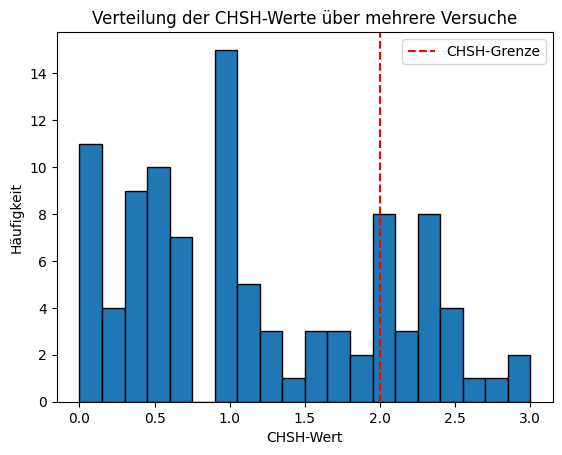

In [3]:
import matplotlib.pyplot as plt

diagonal_basis = 'Y'

def chsh_violation(a_basis, b_basis, outcomes):
    """
    Berechnung des CHSH-Ausdrucks, um Eavesdropping zu erkennen.
    CHSH-Formel: S = |E(a1, b1) - E(a1, b2) + E(a2, b1) + E(a2, b2)|
    """
    E = {(computational_basis, computational_basis): 0, 
         (computational_basis, hadamard_basis): 0, 
         (hadamard_basis, computational_basis): 0, 
         (hadamard_basis, hadamard_basis): 0}
    counts = {(computational_basis, computational_basis): 0, 
              (computational_basis, hadamard_basis): 0, 
              (hadamard_basis, computational_basis): 0, 
              (hadamard_basis, hadamard_basis): 0}

    for basis_pair, result_pair in zip(zip(a_basis, b_basis), outcomes):
        a, b = basis_pair
        result_a, result_b = result_pair

        if (a, b) in E:
            counts[(a, b)] += 1
            E[(a, b)] += 1 if result_a == result_b else -1

    # Durchschnittliche Korrelation berechnen
    for key in E.keys():
        if counts[key] > 0:
            E[key] /= counts[key]

    # CHSH-Ausdruck berechnen (nur positive Werte berücksichtigen)
    S = abs(E[(computational_basis, computational_basis)] - E[(computational_basis, hadamard_basis)] + 
            E[(hadamard_basis, computational_basis)] + E[(hadamard_basis, hadamard_basis)])
    return S

def e91_protocol_with_eavesdropper(n):
    # Simulation initialisieren
    aer_simulator = AerSimulator()

    # Alice, Bob und Eve wählen Zufallsbasen (einschließlich diagonal_basis)
    all_bases = [computational_basis, hadamard_basis, diagonal_basis]
    alice_bases = np.random.choice(all_bases, size=n)
    bob_bases = np.random.choice(all_bases, size=n)
    eve_bases = np.random.choice(all_bases, size=n)

    # Ergebnisse initialisieren
    alice_results = []
    bob_results = []
    eve_results = []
    outcomes = []

    # Quantenregister und Schaltkreis erstellen
    qreg = QuantumRegister(2, "q")
    creg = ClassicalRegister(2, "c")
    circuit = QuantumCircuit(qreg, creg)

    for i in range(n):
        circuit.reset(qreg)

        # Erzeugung von verschränkten Qubits (Bell-Zustand)
        circuit.h(qreg[0])
        circuit.cx(qreg[0], qreg[1])

        # Eve misst mit ihrer Basis
        if eve_bases[i] == hadamard_basis:
            circuit.h(qreg[0])
        elif eve_bases[i] == diagonal_basis:
            circuit.s(qreg[0])
            circuit.h(qreg[0])
        circuit.measure(qreg[0], creg[0])

        eve_result = aer_simulator.run(circuit, shots=1).result()
        eve_counts = eve_result.get_counts()
        eve_outcome = int(list(eve_counts.keys())[0][0])
        eve_results.append(eve_outcome)

        # Qubit neu präparieren basierend auf Eves Ergebnis
        circuit.reset(qreg[0])
        if eve_outcome == 1:
            circuit.x(qreg[0])
        if eve_bases[i] == hadamard_basis:
            circuit.h(qreg[0])
        elif eve_bases[i] == diagonal_basis:
            circuit.sdg(qreg[0])
            circuit.h(qreg[0])

        # Alice misst
        if alice_bases[i] == hadamard_basis:
            circuit.h(qreg[0])
        elif alice_bases[i] == diagonal_basis:
            circuit.s(qreg[0])
            circuit.h(qreg[0])
        circuit.measure(qreg[0], creg[0])

        result_a = aer_simulator.run(circuit, shots=1).result()
        alice_counts = result_a.get_counts()
        alice_outcome = int(list(alice_counts.keys())[0][0])
        alice_results.append(alice_outcome)

        # Bob misst
        if bob_bases[i] == hadamard_basis:
            circuit.h(qreg[1])
        elif bob_bases[i] == diagonal_basis:
            circuit.s(qreg[1])
            circuit.h(qreg[1])
        circuit.measure(qreg[1], creg[1])

        result_b = aer_simulator.run(circuit, shots=1).result()
        bob_counts = result_b.get_counts()
        bob_outcome = int(list(bob_counts.keys())[0][0])
        bob_results.append(bob_outcome)

        outcomes.append((alice_outcome, bob_outcome))

    # Berechnung der CHSH-Ungleichung
    chsh_value = chsh_violation(alice_bases, bob_bases, outcomes)
    detected = chsh_value < 2  # S-Wert kleiner als 2 -> Eve wurde entdeckt

    table = Table(title="E91 Protocol Simulation (Last Run)", show_header=True, header_style="bold white")
    table.add_column("Alice's Basis", justify="center")
    table.add_column("Alice's Result", justify="center")
    table.add_column("Eve's Basis", justify="center")
    table.add_column("Eve's Result", justify="center")
    table.add_column("Bob's Basis", justify="center")
    table.add_column("Bob's Result", justify="center")
    table.add_column("CHSH Value", justify="center", style="bold red" if detected else "bold green")

    for i in range(n):
        table.add_row(
            alice_bases[i],
            str(alice_results[i]),
            eve_bases[i],
            str(eve_results[i]),
            bob_bases[i],
            str(bob_results[i]),
            f"{chsh_value:.2f}"
        )

    return table, chsh_value

n_bits = 20
repeats = 100

chsh_values = []
results = []

for _ in range(repeats):
    table, chsh_value = e91_protocol_with_eavesdropper(n_bits)
    chsh_values.append(chsh_value)
    results.append(table)
console = Console()
console.print("\nLetzte Iteration:")
console.print(results[-1])

print(f"\nLetzter S-Wert: {chsh_values[-1]:.2f} -> {'Eve wurde bemerkt!' if chsh_values[-1] <= 2 else 'Eve konnte unbemerkt lauschen.'}")
print(f"\nDurchschnittlicher CHSH-Wert über {repeats} Wiederholungen: {np.mean(chsh_values):.2f}")
detected = sum(chsh <= 2 for chsh in chsh_values)
print(f"Eve wurde {detected} von {repeats} Malen entdeckt!")

plt.hist(chsh_values, bins=20, edgecolor="black")
plt.title("Verteilung der CHSH-Werte über mehrere Versuche")
plt.xlabel("CHSH-Wert")
plt.ylabel("Häufigkeit")
plt.axvline(x=2, color="red", linestyle="--", label="CHSH-Grenze")
plt.legend()
plt.show()

The following code shows how we implemented the E91 protocol without Eavesdropper. The generated key is then used to encrypt a text using XOR.

In [4]:
def e91_protocol_no_eavesdropper(n, bases=[computational_basis, hadamard_basis, diagonal_basis]):
    """
    E91-Protokoll ohne Eavesdropper, inklusive Schlüsselgenerierung.
    """
    # Simulation initialisieren
    aer_simulator = AerSimulator()

    # Alice und Bob wählen Zufallsbasen
    alice_bases = np.random.choice(bases, size=n)
    bob_bases = np.random.choice(bases, size=n)

    # Ergebnisse und Schlüssel initialisieren
    alice_results = []
    bob_results = []
    shared_key = []
    outcomes = []

    # Quantenregister und Schaltkreis erstellen
    qreg = QuantumRegister(2, "q")
    creg = ClassicalRegister(2, "c")
    circuit = QuantumCircuit(qreg, creg)

    for i in range(n):
        circuit.reset(qreg)

        # Erzeugung von verschränkten Qubits (Bell-Zustand)
        circuit.h(qreg[0])
        circuit.cx(qreg[0], qreg[1])

        # Alice misst in ihrer Basis
        if alice_bases[i] == hadamard_basis:
            circuit.h(qreg[0])
        elif alice_bases[i] == diagonal_basis:
            circuit.ry(np.pi / 4, qreg[0])
        circuit.measure(qreg[0], creg[0])

        # Ergebnis von Alice
        alice_result = aer_simulator.run(circuit, shots=1).result()
        alice_counts = alice_result.get_counts()
        alice_outcome = int(list(alice_counts.keys())[0][1])
        alice_results.append(alice_outcome)

        # Bob misst in seiner Basis
        if bob_bases[i] == hadamard_basis:
            circuit.h(qreg[1])
        elif bob_bases[i] == diagonal_basis:
            circuit.ry(np.pi / 4, qreg[1])
        circuit.measure(qreg[1], creg[1])

        # Ergebnis von Bob
        bob_result = aer_simulator.run(circuit, shots=1).result()
        bob_counts = bob_result.get_counts()
        bob_outcome = int(list(bob_counts.keys())[0][0])
        bob_results.append(bob_outcome)

        outcomes.append((alice_outcome, bob_outcome))

        # Schlüssel teilen, wenn Alice und Bob die gleiche Basis verwenden
        if alice_bases[i] == bob_bases[i]:
            shared_key.append(alice_outcome)

    # Rückgabe der Ergebnisse
    return alice_bases, bob_bases, alice_results, bob_results, shared_key


def xor_encrypt_decrypt(message, key):
    """
    Verschlüsselt oder entschlüsselt eine Nachricht mit dem Schlüssel mittels XOR.
    """
    message_bits = [int(bit) for bit in ''.join(format(ord(c), '08b') for c in message)]
    processed_bits = [message_bits[i] ^ key[i % len(key)] for i in range(len(message_bits))]
    processed_message = ''.join(chr(int(''.join(map(str, processed_bits[i:i + 8])), 2)) for i in range(0, len(processed_bits), 8))
    return processed_message


n_bits = 50
alice_bases, bob_bases, alice_results, bob_results, key = e91_protocol_no_eavesdropper(n_bits)

print("Generierter Schlüssel:", key)

# Nachricht verschlüsseln und entschlüsseln
message = "Hello World!"
encrypted_message = xor_encrypt_decrypt(message, key)
decrypted_message = xor_encrypt_decrypt(encrypted_message, key)

print("Originalnachricht:", message)
print("Verschlüsselte Nachricht:", encrypted_message)
print("Entschlüsselte Nachricht:", decrypted_message)

Generierter Schlüssel: [0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1]
Originalnachricht: Hello World!
Verschlüsselte Nachricht: %ÄrTÉÒ°/
Entschlüsselte Nachricht: Hello World!


## Summary E91

**We simulated the E91 principle using Qiskit:**
    - Performed measurements in different bases.
    - Calculated the CHSH parameter.
    - Presented visualizations of the CHSH distribution.

The E91 protocol demonstrates how entanglement and the violation of local realism inequalities can be used for secure key exchange.
In a real QKD application (whether E91 or BB84), additional protocol layers are involved: error correction and privacy amplification.

Further ideas:

- Generalize the angles, e.g., measurements at 0°, 45°, 22.5°, -22.5°.
- Fully implement the CHSH parameter by performing 4 measurement circuits and calculating $S$ at the end.
- Use visualization tools to display Bob's and Alice's measurement distributions/histograms.
- Introduce noise or qubit errors (e.g., using Qiskit noise models) to observe the impact on the QKD system.


## Sources & Literature

- https://www.youtube.com/watch?v=V3WzH2up7Os
- https://www.youtube.com/watch?v=NNUTqggOhq0&t=
- Artur K. Ekert (1991). \"Quantum Cryptography Based on Bell’s Theorem.\" Physical Review Letters 67, 661
- Nielsen & Chuang (2010). *Quantum Computation and Quantum Information*.
- [Qiskit Doku und Tutorials](https://qiskit.org/documentation/)